In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,\
 classification_report, balanced_accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
def my_balanced_accuracy(tn, fp, fn, tp):
  tpr = tp/(tp+fn)
  tnr = tn/(tn+fp)
  return 0.5 * (tpr+tnr)

In [ ]:
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.99], random_state=0)

Xtest, ytest = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.5, 0.5], random_state=0)

In [ ]:
Xtest

array([[-0.4002285 , -0.92688039],
       [ 1.07610199,  1.18029069],
       [-0.92295314,  0.30616655],
       ...,
       [-2.37673965,  3.03728951],
       [-1.07726236,  1.45397626],
       [ 1.38028997,  0.87341245]])

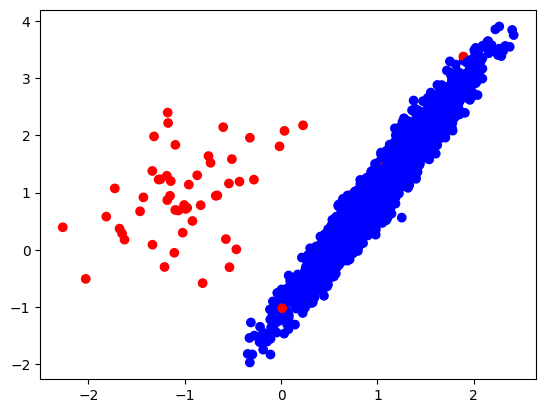

In [ ]:
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

In [ ]:
Xval, yval = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.99],
                           class_sep=0.8, random_state=0)

In [ ]:
X.shape

(5000, 2)

In [ ]:
print(sorted(Counter(y).items()))
print(sorted(Counter(ytest).items()))

[(0, 77), (1, 4923)]
[(0, 501), (1, 499)]


In [ ]:
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [ ]:
preds = clf.predict(Xtest)
print(classification_report(ytest, preds))
print(balanced_accuracy_score(ytest, preds))
tn, fp, fn, tp = confusion_matrix(ytest, preds).ravel()
print(my_balanced_accuracy(tn, fp, fn, tp))
#print(classification_report_imbalanced(ytest, preds))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86       501
           1       0.82      0.97      0.89       499

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

0.877189508758035
0.877189508758035


In [ ]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0, 4923), (1, 4923)]


In [ ]:
clf2 = LogisticRegression()
clf2.fit(X_resampled, y_resampled)

LogisticRegression()

In [ ]:
def eval_clf(clf, Xtest, ytest):
  preds = clf.predict(Xtest)
  print(classification_report(ytest, preds))
  print(balanced_accuracy_score(ytest, preds))
  tn, fp, fn, tp = confusion_matrix(ytest, preds).ravel()
  print(my_balanced_accuracy(tn, fp, fn, tp))

In [ ]:
X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled_smote).items()))
clf_smote = LogisticRegression().fit(X_resampled_smote, y_resampled_smote)
X_resampled_ada, y_resampled_ada = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled_ada).items()))
clf_adasyn = LogisticRegression().fit(X_resampled_ada, y_resampled_ada)

[(0, 4923), (1, 4923)]
[(0, 4934), (1, 4923)]


In [ ]:
eval_clf(clf2, Xtest, ytest) # Random

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       501
           1       0.90      0.72      0.80       499

    accuracy                           0.82      1000
   macro avg       0.84      0.82      0.82      1000
weighted avg       0.84      0.82      0.82      1000

0.8227972911891648
0.8227972911891648


In [ ]:
eval_clf(clf_smote, Xtest, ytest) # Smote

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       501
           1       0.90      0.73      0.80       499

    accuracy                           0.82      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000

0.8218072872291489
0.8218072872291489


In [ ]:
eval_clf(clf_adasyn, Xtest, ytest) # ADA

              precision    recall  f1-score   support

           0       0.68      0.96      0.79       501
           1       0.93      0.54      0.68       499

    accuracy                           0.75      1000
   macro avg       0.80      0.75      0.74      1000
weighted avg       0.80      0.75      0.74      1000

0.7505810023240094
0.7505810023240094


In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=X.shape[1])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(50, activation="relu")(Z)
Z = tf.keras.layers.Dense(25, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(25, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(50, activation="relu")(x)
x = tf.keras.layers.Dense(X.shape[1])(x)
outputs = tf.keras.layers.Reshape([X.shape[1]])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss))

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")

In [ ]:
X0 = []
X1 = []
for m,n in zip(X,y):
  if (n == 1):
    X1.append(m)
  else: X0.append(m)
X0 = pd.DataFrame(X0)
X1 = pd.DataFrame(X1)

In [ ]:
history = variational_ae.fit(X0, X0, epochs=25, batch_size=20) #validation_data=(Xval, Xval),
tf.random.set_seed(42)
codings = tf.random.normal(shape=[(4923 - 77), codings_size])
outs = variational_decoder(codings).numpy()
y_new = pd.DataFrame(np.zeros(len(outs)), columns=["Label"], dtype=int)
x_new = pd.DataFrame(outs, columns=["x0", "x1"])
df_new = pd.concat([x_new, y_new], axis=1)
df_new
y_old = pd.DataFrame(y, columns=["Label"], dtype=int)
x_old = pd.DataFrame(X, columns=["x0", "x1"])
df_old = pd.concat([x_old, y_old], axis=1)
df = pd.concat([df_new, df_old])
df = df.sample(frac = 1)
df
clf_vae = LogisticRegression()
clf_vae.fit(X,y)
ytest = pd.DataFrame(ytest, columns=["Label"], dtype=int)
Xtest = pd.DataFrame(Xtest, columns=["x0", "x1"])
eval_clf(clf_vae, Xtest, ytest)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
codings = tf.random.normal(shape=[(4923 - 77), codings_size])
outs = variational_decoder(codings).numpy()
outs


array([[-0.39290735,  1.0059215 ],
       [-0.3670918 ,  0.95657307],
       [-0.34159872,  0.9701499 ],
       ...,
       [-0.17414078,  0.80087477],
       [-0.22441804,  0.95093405],
       [-0.29428196,  0.95596963]], dtype=float32)

In [ ]:
y_new = pd.DataFrame(np.zeros(len(outs)), columns=["Label"], dtype=int)
x_new = pd.DataFrame(outs, columns=["x0", "x1"])
df_new = pd.concat([x_new, y_new], axis=1)
df_new

,x0,x1,Label
0,-0.392907,1.005921,0
1,-0.367092,0.956573,0
2,-0.341599,0.970150,0
3,-0.122048,0.900363,0
4,-0.173662,0.765667,0
...,...,...,...
4841,-0.603335,1.226874,0
4842,-0.334846,0.936220,0
4843,-0.174141,0.800875,0
4844,-0.224418,0.950934,0


In [ ]:
y_old = pd.DataFrame(y, columns=["Label"], dtype=int)
x_old = pd.DataFrame(X, columns=["x0", "x1"])
df_old = pd.concat([x_old, y_old], axis=1)
df = pd.concat([df_new, df_old])
df

,x0,x1,Label
0,-0.392907,1.005921,0
1,-0.367092,0.956573,0
2,-0.341599,0.970150,0
3,-0.122048,0.900363,0
4,-0.173662,0.765667,0
...,...,...,...
4995,0.929973,1.054424,1
4996,1.214877,2.010915,1
4997,0.751787,0.812165,1
4998,1.960089,2.621576,1


In [ ]:
df["Label"].value_counts()

0    4923
1    4923
Name: Label, dtype: int64

In [ ]:
df = df.sample(frac = 1)

In [ ]:
y = df["Label"]
X = df[["x0", "x1"]]
X

,x0,x1
4781,-0.243119,0.852347
4760,1.422319,2.215946
4480,-0.445562,1.103820
3191,-0.318023,0.882529
2114,1.523987,2.129212
...,...,...
1634,-0.250004,1.000281
736,1.100250,0.771907
3587,0.750426,0.641011
3997,0.790799,0.521419


In [ ]:
clf_vae = LogisticRegression()
clf_vae.fit(X,y)
#eval_clf(clf_vae, Xtest, ytest)

LogisticRegression()

In [ ]:
ytest = pd.DataFrame(ytest, columns=["Label"], dtype=int)
Xtest = pd.DataFrame(Xtest, columns=["x0", "x1"])

In [ ]:
eval_clf(clf_vae, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       501
           1       0.88      0.84      0.86       499

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

0.8609574438297753
0.8609574438297753


In [ ]:
from imblearn.datasets import fetch_datasets

ecoli = fetch_datasets()["ecoli"]
X, y = ecoli.data, ecoli.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
print(sorted(Counter(y_train).items()))

[(-1, 224), (1, 28)]


In [ ]:
clf_0 = LogisticRegression()
clf_0.fit(X_train,y_train)
eval_clf(clf_0, X_test, y_test)

              precision    recall  f1-score   support

          -1       0.92      0.99      0.95        77
           1       0.00      0.00      0.00         7

    accuracy                           0.90        84
   macro avg       0.46      0.49      0.47        84
weighted avg       0.84      0.90      0.87        84

0.4935064935064935
0.4935064935064935


In [ ]:
ros = RandomOverSampler(random_state=0)
X_resampled_r, y_resampled_r = ros.fit_resample(X_train,y_train)
print(sorted(Counter(y_resampled_r).items()))
clf_1 = LogisticRegression()
clf_1.fit(X_resampled_r, y_resampled_r)
X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train,y_train)
print(sorted(Counter(y_resampled_smote).items()))
clf_smote = LogisticRegression().fit(X_resampled_smote, y_resampled_smote)
X_resampled_ada, y_resampled_ada = ADASYN().fit_resample(X_train,y_train)
print(sorted(Counter(y_resampled_ada).items()))
clf_adasyn = LogisticRegression().fit(X_resampled_ada, y_resampled_ada)
eval_clf(clf_1, X_test, y_test) # Random
eval_clf(clf_smote, X_test, y_test) # Smote
eval_clf(clf_adasyn, X_test, y_test) # ADA

[(-1, 224), (1, 224)]
[(-1, 224), (1, 224)]
[(-1, 224), (1, 228)]
              precision    recall  f1-score   support

          -1       1.00      0.88      0.94        77
           1       0.44      1.00      0.61         7

    accuracy                           0.89        84
   macro avg       0.72      0.94      0.77        84
weighted avg       0.95      0.89      0.91        84

0.9415584415584415
0.9415584415584415
              precision    recall  f1-score   support

          -1       1.00      0.87      0.93        77
           1       0.41      1.00      0.58         7

    accuracy                           0.88        84
   macro avg       0.71      0.94      0.76        84
weighted avg       0.95      0.88      0.90        84

0.935064935064935
0.935064935064935
              precision    recall  f1-score   support

          -1       1.00      0.87      0.93        77
           1       0.41      1.00      0.58         7

    accuracy                           0.8

In [ ]:
X_train.shape

(252, 7)

In [ ]:
X0 = []
#X1 = []
for m,n in zip(X_train,y_train):
  if (n == 1):
    X0.append(m)
  else: X0.append(m)
X0 = pd.DataFrame(X0)
#X1 = pd.DataFrame(X1)

In [ ]:
history = variational_ae.fit(X0, X0, epochs=30, batch_size=30)
 #                             validation_data=(X_train[-10:], X_train[-10:])) #

Epoch 1/30
9/9 [==============================] - 2s 3ms/step - loss: 0.5173
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 3/30
9/9 [==============================] - 0s 3ms/step - loss: 0.2057
Epoch 4/30
9/9 [==============================] - 0s 2ms/step - loss: 0.1262
Epoch 5/30
9/9 [==============================] - 0s 2ms/step - loss: 0.1041
Epoch 6/30
9/9 [==============================] - 0s 2ms/step - loss: 0.0877
Epoch 7/30
9/9 [==============================] - 0s 2ms/step - loss: 0.0752
Epoch 8/30
9/9 [==============================] - 0s 2ms/step - loss: 0.0692
Epoch 9/30
9/9 [==============================] - 0s 2ms/step - loss: 0.0664
Epoch 10/30
9/9 [==============================] - 0s 2ms/step - loss: 0.0567
Epoch 11/30
9/9 [==============================] - 0s 2ms/step - loss: 0.0528
Epoch 12/30
9/9 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 13/30
9/9 [==============================] - 0s 2ms/step - loss: 0.

In [ ]:
codings = tf.random.normal(shape=[(224 - 28), codings_size])
outs = variational_decoder(codings).numpy()
y_new = pd.DataFrame(np.ones(len(outs)), columns=["Label"], dtype=int)
x_new = pd.DataFrame(outs)
df_new = pd.concat([x_new, y_new], axis=1)
df_new
y_old = pd.DataFrame(y_train, columns=["Label"], dtype=int)
x_old = pd.DataFrame(X_train) #columns=["x0", "x1"]
df_old = pd.concat([x_old, y_old], axis=1)
df = pd.concat([df_new, df_old])
df = df.sample(frac = 1)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
clf_vae = LogisticRegression()
clf_vae.fit(X,y)
#ytest = pd.DataFrame(y_test, columns=["Label"], dtype=int)
#Xtest = pd.DataFrame(X_test)


LogisticRegression()

In [ ]:
print(sorted(Counter(y).items()))

[(-1, 224), (1, 224)]


In [ ]:
preds = clf_vae.predict(X_test)
print(classification_report(y_test, preds))
print(balanced_accuracy_score(y_test, preds))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(my_balanced_accuracy(tn, fp, fn, tp))

              precision    recall  f1-score   support

          -1       1.00      0.77      0.87        77
           1       0.28      1.00      0.44         7

    accuracy                           0.79        84
   macro avg       0.64      0.88      0.65        84
weighted avg       0.94      0.79      0.83        84

0.8831168831168832
0.8831168831168832


In [ ]:
eval_clf(clf_vae, X_test, y_test)

              precision    recall  f1-score   support

          -1       1.00      0.75      0.86        77
           1       0.27      1.00      0.42         7

    accuracy                           0.77        84
   macro avg       0.63      0.88      0.64        84
weighted avg       0.94      0.77      0.82        84

0.8766233766233766
0.8766233766233766
